# Example of spatial analysis on a region in pancreatic cancer

## Note: calculating mpp for the slide

The slide we are interested in does not have the property "openslide.mpp-x", so instead, I used `tiff.ResolutionUnit` along with `tiff.XResolution`. The resolution unit is centimeters, and xresolution (I think) is pixels per resolution unit. So I did this...

$$
\frac{ResolutionUnit}{XResolution} * \frac{N micrometer}{ResolutionUnit}
$$

where $N micrometer$ is the number of micrometers in one unit of $ResolutionUnit$.

In our case, this was

$$
\frac{1 cm}{2883.244194 pix} * \frac{10,000 \mu m}{1 cm} = 0.34622 \frac{\mu m}{pix}
$$

In [1]:
from pathlib import Path
import tumor_microenv as tm

In [2]:
data_root = Path("data") / "Div_Data2"  # 25 micrometer
patch_paths = list(data_root.glob("*.npy"))
json_paths = list(data_root.glob("*.json"))

loader = tm.LoaderV1(
    patch_paths=patch_paths, 
    cells_json=json_paths, 
    background=0, 
    marker_positive=1, 
    marker_negative=7,
)
patches, cells = loader()
# Optionally filter cells by some condition.
cells = [c for c in cells if c.cell_type in {"cd4", "cd8", "cd16", "cd163"}]

# Get the centroid per cell.
cells = [c._replace(polygon=c.polygon.centroid) for c in cells]

In [3]:
output_csv = Path("output-25micron-100um-centroids.csv")

In [4]:
# This takes several minutes.
tm.run_spatial_analysis(
    patches, 
    cells, 
    microenv_distances=[100], 
    mpp=0.34622,
    output_path=output_csv)

Working on distance = 100 um (289 px)
Filtering cells...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4039/4039 [00:02<00:00, 1455.43it/s]


In [5]:
!du -h "$output_csv"

996K	output-25micron-100um-centroids.csv


# Make histograms from output CSV

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
mpp = 0.34622
df = pd.read_csv(output_csv)
df.loc[:, "dist_to_marker_neg"] *= mpp
df.loc[:, "dist_to_marker_pos"] *= mpp
df.head()

,point,dist_to_marker_neg,dist_to_marker_pos,line_to_marker_neg,line_to_marker_pos,cell_type,cell_uuid,microenv_micrometer
0,POINT (41384.31088082901 25992.62521588947),73.160053,34.858242,LINESTRING (41384.31088082901 25992.6252158894...,LINESTRING (41384.31088082901 25992.6252158894...,cd16,742b889eac084eb1b9b8c913e2e608b3,100
1,POINT (41345.5231392621 26005.55438259757),59.730961,32.336771,LINESTRING (41345.5231392621 26005.55438259757...,LINESTRING (41345.5231392621 26005.55438259757...,cd16,243f4bebbd4c4fa495adfc97a83f8fe7,100
2,POINT (41368.70588235294 25991.01960784314),67.757291,31.157138,LINESTRING (41368.70588235294 25991.0196078431...,LINESTRING (41368.70588235294 25991.0196078431...,cd163,dfdcd53c938347cbb69677182dc07745,100
3,POINT (36934.05241090147 29221.71488469602),52.082256,48.835166,LINESTRING (36934.05241090147 29221.7148846960...,LINESTRING (36934.05241090147 29221.7148846960...,cd163,00ed9532029e49d89e20ddabe2672401,100
4,POINT (40656.58274509804 27832.80705882353),276.518125,18.762680,LINESTRING (40656.58274509804 27832.8070588235...,LINESTRING (40656.58274509804 27832.8070588235...,cd16,383d280631c645aa936045cfa0167139,100


In [8]:
df.shape

(4039, 8)

In [9]:
def get_pdf_and_cdf(values, bins=100):
    values = np.asarray(values)
    count, bins = np.histogram(values, bins=100)
    pdf = count / count.sum()
    cdf = pdf.cumsum()
    return pdf, cdf, bins

def plot_pdf_cdf(pdf, cdf, bins, cell_type, marker_type, ax):
    ax.plot(bins[1:], pdf, color="red", label="PDF")
    ax.plot(bins[1:], cdf, label="CDF")
    ax.legend()
    ax.set_xlabel("Distance (micrometer)")
    ax.set_title(f"{cell_type} distance to marker {marker_type}")
    return ax

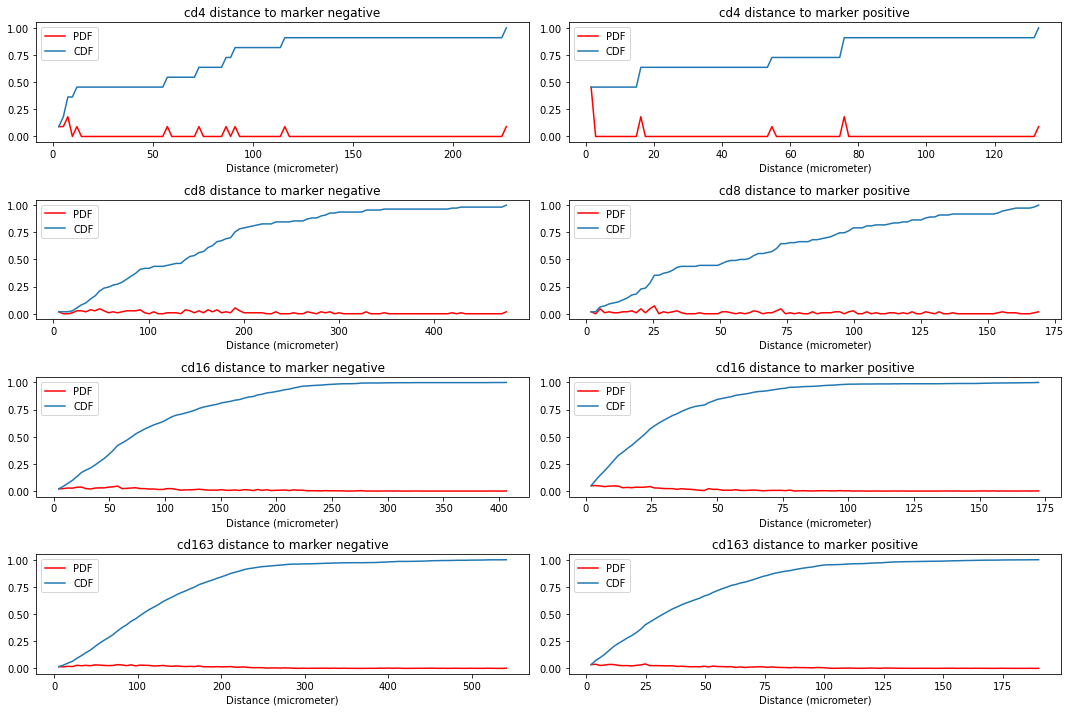

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))
cell_types = ["cd4", "cd8", "cd16", "cd163"]
for i, cell_type in enumerate(cell_types):
    for j, (marker_status, column)  in enumerate(
        [("negative", "dist_to_marker_neg"), ("positive", "dist_to_marker_pos")]):
        
        # Multiply pixels by mpp to get distance in micrometers.
        pdf, cdf, bins = get_pdf_and_cdf(df.query(f"cell_type=='{cell_type}'").loc[:, column])
        plot_pdf_cdf(pdf, cdf, bins, cell_type=cell_type, marker_type=marker_status, ax=axes[i, j])
fig.tight_layout()
plt.savefig("/tmp/hist.pdf")

### Plot again but now with one plot per cell type (include M+ and M- in same plot)

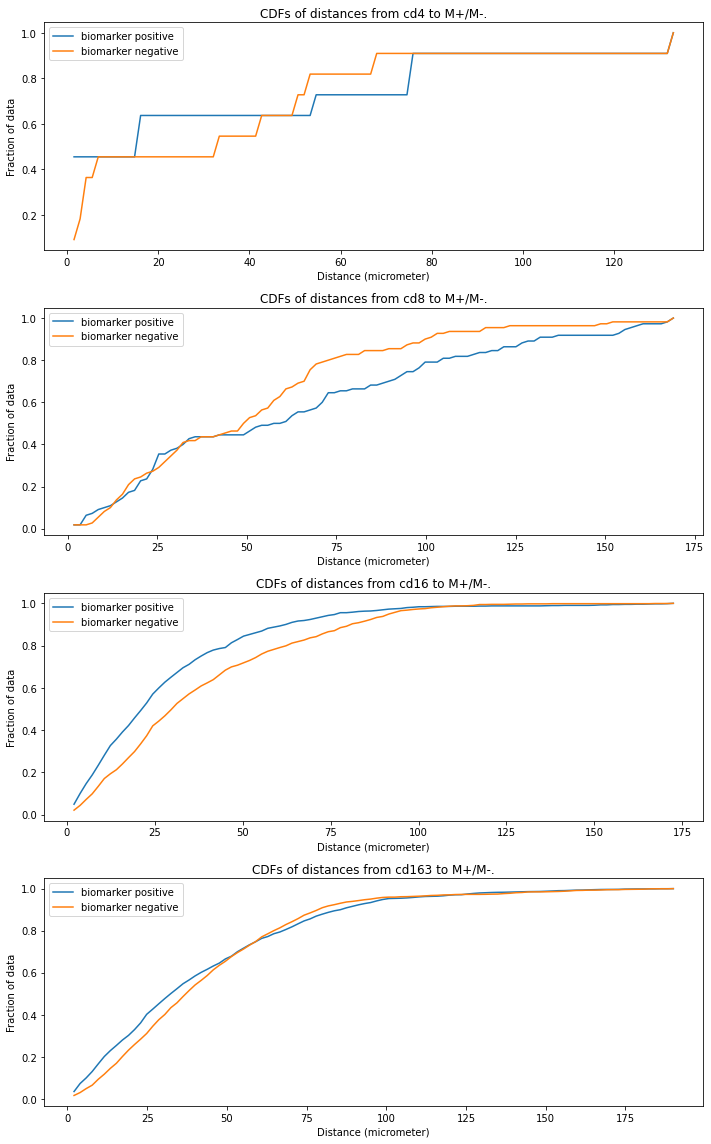

In [11]:
def plot_cdfs_per_celltype(cdf_pos, cdf_neg, bins, cell_type, ax):
    ax.plot(bins[1:], cdf_pos, label="biomarker positive")
    ax.plot(bins[1:], cdf_neg, label="biomarker negative")
    ax.legend()
    ax.set_xlabel("Distance (micrometer)")
    ax.set_ylabel("Fraction of data")
    ax.set_title(f"CDFs of distances from {cell_type} to M+/M-.")
    return ax

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 16))
cell_types = ["cd4", "cd8", "cd16", "cd163"]
for i, cell_type in enumerate(cell_types):
    _tmp_df = df.query(f"cell_type=='{cell_type}'")
    _, cdf_neg, bins = get_pdf_and_cdf(_tmp_df.loc[:, "dist_to_marker_neg"])
    _, cdf_pos, bins = get_pdf_and_cdf(_tmp_df.loc[:, "dist_to_marker_pos"])
    plot_cdfs_per_celltype(
        cdf_pos=cdf_pos, cdf_neg=cdf_neg, bins=bins, cell_type=cell_type, ax=axes[i])

fig.tight_layout()
plt.savefig("/tmp/cdfs.pdf")
plt.show()

In [12]:
# TODO: add KS test

# Overlay patches and points on IHC

In [13]:
from collections import Counter
from pathlib import Path

In [14]:
data_root = Path("data/Div_Data2/")
patch_paths = list(data_root.glob("*.npy"))
json_paths = list(data_root.glob("*.json"))

loader = tm.LoaderV1(
    patch_paths=patch_paths, 
    cells_json=json_paths, 
    background=0,
    marker_positive=1, 
    marker_negative=7,
)
patches, cells = loader()
cells = [c for c in cells if c.cell_type in {"cd3", "cd4", "cd8", "cd16", "cd163"}]
# Get the centroid per cell.
cells = [c._replace(polygon=c.polygon.centroid) for c in cells]

Counter(patch.patch_type for patch in patches)

Counter({<PatchType.TUMOR: 1>: 2697,
         <PatchType.BLANK: 0>: 1789,
         <PatchType.NONTUMOR: 2>: 2570})

In [15]:
points_data = tm.read_point_csv(output_csv)

In [16]:
import cv2

image = cv2.imread("data/merged_image.png")
assert image is not None
image = tm.cv2_add_patch_exteriors(image, patches=patches)
image = tm.cv2_add_cell_points(image, points_data=points_data)
image = tm.cv2_add_cell_distance_lines(image, points_data=points_data)
assert cv2.imwrite("overlay.png", image)